In [1]:
import pandas as pd
import numpy as np
import requests

with open("SECRET.gitignore", "r") as file:
    CLIENT_ID = file.readline().strip()
    SECRET_KEY = file.readline().strip()
    USERNAME = file.readline().strip()
    PASSWORD = file.readline().strip()


In [2]:
auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)
data = {"grant_type": "password", "username": USERNAME, "password":PASSWORD}
header = {"User-Agent": "MyAPI/0.0.1"}

In [3]:
res = requests.post("https://www.reddit.com/api/v1/access_token", auth=auth, data=data, headers=header)
TOKEN = res.json()["access_token"]
header["Authorization"] = f"bearer {TOKEN}"

In [4]:
res = requests.get("https://oauth.reddit.com/r/politics/hot", headers=header, params={"limit": 100})

In [5]:
temp_dict = {"Title":[], "SelfText":[], "Upvote":[], "Downvote": []}

if res.status_code == 200:
    posts = res.json()["data"]["children"]
    
    for post in posts:
        temp_dict["Title"].append(post["data"]["title"])
        temp_dict["SelfText"].append(post["data"]["selftext"])
        temp_dict["Upvote"].append(post["data"]["ups"])
        temp_dict["Downvote"].append(post["data"]["downs"])
    
df = pd.DataFrame(temp_dict)
df = df.loc[1:]
df

,Title,SelfText,Upvote,Downvote
1,Liz Cheney Tells George W. Bush to Endorse Kam...,,30036,0
2,Team Trump Panics as “Hell” Breaks Loose in El...,,10412,0
3,Poll: Puerto Ricans in Florida overwhelmingly ...,,14720,0
4,Elon Musk $1 million voter lottery suit sent b...,,18276,0
5,Kamala Harris ahead in enough swing states to ...,,12657,0
...,...,...,...,...
96,"Election workers are exhausted, abused and rea...",,255,0
97,"""Avengers"" cast endorse Kamala Harris",,96,0
98,Jennifer Lopez says Puerto Rico 'island of gar...,,422,0
99,Pro-Trump columnist Hugh Hewitt dramatically q...,,121,0


In [6]:
def identify_candidates(title):
    title = title.lower()
    if "trump" in title or "donald" in title:
        return "Trump"
    elif "kamala" in title or "harris" in title:
        return "Kamala"
    else:
        return np.nan
    
df["Candidate"]= df["Title"].apply(identify_candidates)
df["Candidate"].value_counts()

Candidate
Trump     48
Kamala    19
Name: count, dtype: int64

In [7]:
df.head(15)

,Title,SelfText,Upvote,Downvote,Candidate
1,Liz Cheney Tells George W. Bush to Endorse Kam...,,30036,0,Kamala
2,Team Trump Panics as “Hell” Breaks Loose in El...,,10412,0,Trump
3,Poll: Puerto Ricans in Florida overwhelmingly ...,,14720,0,Trump
4,Elon Musk $1 million voter lottery suit sent b...,,18276,0,NaN
5,Kamala Harris ahead in enough swing states to ...,,12657,0,Kamala
6,Many young voters are watching Trump's 'Access...,,3154,0,Trump
7,"""That is sick!"": Newt Gingrich loses it over a...",,26492,0,Kamala
8,Trump's Liz Cheney Remarks Probed by AG as Pos...,,7926,0,Trump
9,Trump loses $2.4 billion in net worth after hi...,,4364,0,Trump
10,Trump’s ‘grab them’ comment was history. Now T...,,2934,0,Trump


In [8]:
df.dropna(subset=['Candidate'], inplace=True)
df.reset_index(drop=True,inplace=True)
df


,Title,SelfText,Upvote,Downvote,Candidate
0,Liz Cheney Tells George W. Bush to Endorse Kam...,,30036,0,Kamala
1,Team Trump Panics as “Hell” Breaks Loose in El...,,10412,0,Trump
2,Poll: Puerto Ricans in Florida overwhelmingly ...,,14720,0,Trump
3,Kamala Harris ahead in enough swing states to ...,,12657,0,Kamala
4,Many young voters are watching Trump's 'Access...,,3154,0,Trump
...,...,...,...,...,...
62,Who Has Donald Trump Threatened With Death or ...,,294,0,Trump
63,"""Avengers"" cast endorse Kamala Harris",,96,0,Kamala
64,Jennifer Lopez says Puerto Rico 'island of gar...,,422,0,Trump
65,Pro-Trump columnist Hugh Hewitt dramatically q...,,121,0,Trump


In [9]:
from gensim.parsing.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
import string

stemming = PorterStemmer()
stopwords = stopwords.words("english")

def clean_data(text):
    text = text.lower()
    text = word_tokenize(text)
    
    #remove stopwords
    temp = []
    for word in text:
        # Remove punctuation before checking for stopwords
        punc_free = ''.join([ch for ch in word if ch not in string.punctuation])
        if punc_free and punc_free not in stopwords and not punc_free.isdigit():
            temp.append(punc_free)
            
    stem = []
    for item in temp:
        if len(item) >=2:
            stem.append(stemming.stem(item))
            
    return stem


df["clean text"] = df["Title"].apply(clean_data)
df["clean text"] = df["clean text"].apply(lambda x: ' '.join(x))
df

,Title,SelfText,Upvote,Downvote,Candidate,clean text
0,Liz Cheney Tells George W. Bush to Endorse Kam...,,30036,0,Kamala,liz chenei tell georg bush endors kamala harri...
1,Team Trump Panics as “Hell” Breaks Loose in El...,,10412,0,Trump,team trump panic hell break loos elon musk vot...
2,Poll: Puerto Ricans in Florida overwhelmingly ...,,14720,0,Trump,poll puerto rican florida overwhelmingli suppo...
3,Kamala Harris ahead in enough swing states to ...,,12657,0,Kamala,kamala harri ahead enough swing state win time...
4,Many young voters are watching Trump's 'Access...,,3154,0,Trump,mani young voter watch trump access hollywood ...
...,...,...,...,...,...,...
62,Who Has Donald Trump Threatened With Death or ...,,294,0,Trump,donald trump threaten death violenc
63,"""Avengers"" cast endorse Kamala Harris",,96,0,Kamala,aveng cast endors kamala harri
64,Jennifer Lopez says Puerto Rico 'island of gar...,,422,0,Trump,jennif lopez sai puerto rico island garbag tru...
65,Pro-Trump columnist Hugh Hewitt dramatically q...,,121,0,Trump,protrump columnist hugh hewitt dramat quit was...


In [10]:
sentiment = SentimentIntensityAnalyzer()
df["SentimentScore"] = df["clean text"].apply(lambda x: sentiment.polarity_scores(x)["compound"])
df.head()

,Title,SelfText,Upvote,Downvote,Candidate,clean text,SentimentScore
0,Liz Cheney Tells George W. Bush to Endorse Kam...,,30036,0,Kamala,liz chenei tell georg bush endors kamala harri...,0.0000
1,Team Trump Panics as “Hell” Breaks Loose in El...,,10412,0,Trump,team trump panic hell break loos elon musk vot...,-0.8360
2,Poll: Puerto Ricans in Florida overwhelmingly ...,,14720,0,Trump,poll puerto rican florida overwhelmingli suppo...,0.4019
3,Kamala Harris ahead in enough swing states to ...,,12657,0,Kamala,kamala harri ahead enough swing state win time...,0.5859
4,Many young voters are watching Trump's 'Access...,,3154,0,Trump,mani young voter watch trump access hollywood ...,0.0000


In [11]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

df["Upvote scaled"] = scalar.fit_transform(df[["Upvote"]])
df["Downvote scaled"] = scalar.fit_transform(df[["Downvote"]])
df["Candidate label"] = df["Candidate"].apply(lambda x: 0 if x == "Trump" else 1) #Encode candidate label, Trump == 0 & Kamala == 1
df

,Title,SelfText,Upvote,Downvote,Candidate,clean text,SentimentScore,Upvote scaled,Downvote scaled,Candidate label
0,Liz Cheney Tells George W. Bush to Endorse Kam...,,30036,0,Kamala,liz chenei tell georg bush endors kamala harri...,0.0000,0.638162,0.0,1
1,Team Trump Panics as “Hell” Breaks Loose in El...,,10412,0,Trump,team trump panic hell break loos elon musk vot...,-0.8360,0.219882,0.0,0
2,Poll: Puerto Ricans in Florida overwhelmingly ...,,14720,0,Trump,poll puerto rican florida overwhelmingli suppo...,0.4019,0.311706,0.0,0
3,Kamala Harris ahead in enough swing states to ...,,12657,0,Kamala,kamala harri ahead enough swing state win time...,0.5859,0.267734,0.0,1
4,Many young voters are watching Trump's 'Access...,,3154,0,Trump,mani young voter watch trump access hollywood ...,0.0000,0.065180,0.0,0
...,...,...,...,...,...,...,...,...,...,...
62,Who Has Donald Trump Threatened With Death or ...,,294,0,Trump,donald trump threaten death violenc,-0.7579,0.004220,0.0,0
63,"""Avengers"" cast endorse Kamala Harris",,96,0,Kamala,aveng cast endors kamala harri,0.0000,0.000000,0.0,1
64,Jennifer Lopez says Puerto Rico 'island of gar...,,422,0,Trump,jennif lopez sai puerto rico island garbag tru...,0.0000,0.006949,0.0,0
65,Pro-Trump columnist Hugh Hewitt dramatically q...,,121,0,Trump,protrump columnist hugh hewitt dramat quit was...,0.0000,0.000533,0.0,0


In [12]:
df["Exponential Sentiment"] = df["SentimentScore"] * np.exp(df["Upvote scaled"])
df["Exponential Sentiment"]

0     0.000000
1    -1.041598
2     0.548896
3     0.765771
4     0.000000
        ...   
62   -0.761105
63    0.000000
64    0.000000
65    0.000000
66   -0.896177
Name: Exponential Sentiment, Length: 67, dtype: float64

In [13]:
avg_sentiment = df.groupby("Candidate")["Exponential Sentiment"].mean()
print("Average Sentiment Score by Candidate:")
print(avg_sentiment)
print("="*45)

df["SentimentCategory"] = df["Exponential Sentiment"].apply(lambda x: "Positive" if x > 0 else "Negative")
sentiment_count = df.groupby(["Candidate", "SentimentCategory"]).size().unstack()
print("Sentiment Counts by Candidate:")
print(sentiment_count)


Average Sentiment Score by Candidate:
Candidate
Kamala    0.066132
Trump    -0.227737
Name: Exponential Sentiment, dtype: float64
Sentiment Counts by Candidate:
SentimentCategory  Negative  Positive
Candidate                            
Kamala                   13         6
Trump                    42         6


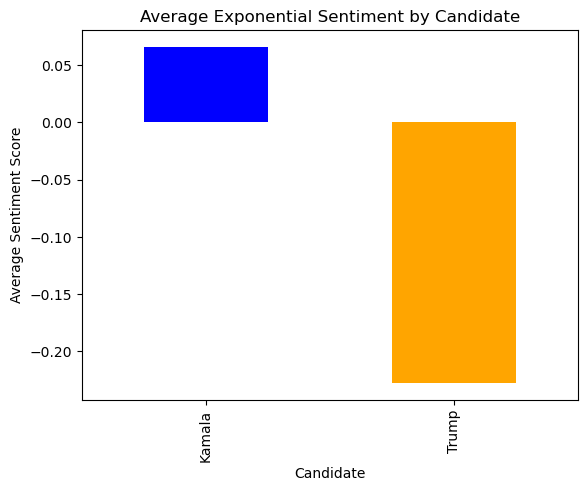

In [14]:
import matplotlib.pyplot as plt
avg_sentiment.plot(kind="bar", color=["blue", "orange"], title="Average Exponential Sentiment by Candidate")
plt.ylabel("Average Sentiment Score")
plt.xlabel("Candidate")
plt.show()

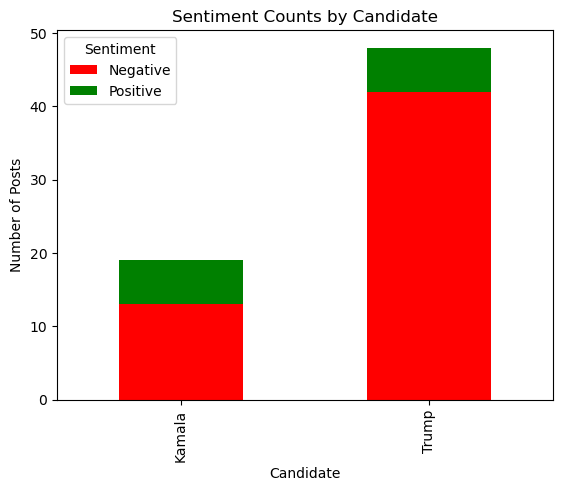

In [15]:
sentiment_count.plot(kind="bar", stacked=True, color=["red", "green"], title="Sentiment Counts by Candidate")
plt.ylabel("Number of Posts")
plt.xlabel("Candidate")
plt.legend(title="Sentiment")
plt.show()


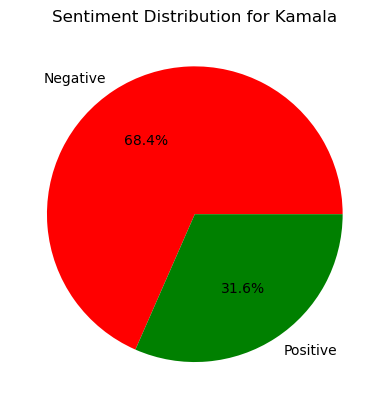

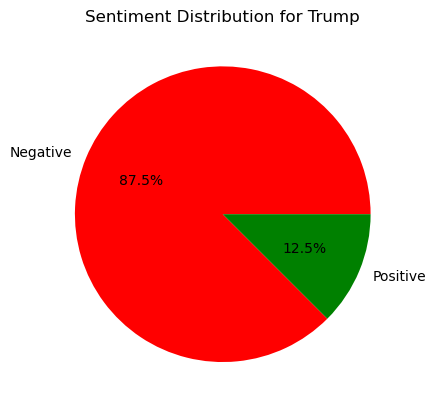

In [16]:
for candidate in sentiment_count.index:
    sentiment_count.loc[candidate].plot(kind="pie", autopct='%1.1f%%', title=f"Sentiment Distribution for {candidate}", colors=["red", "green"])
    plt.ylabel("")  # Hide the y-label for a cleaner look
    plt.show()

# Distribution of sentiment values for each candidate across a range of sentiment scores

- Peaks in each plot represent ranges of sentiment scores that are more frequent.
- Kamala’s density plot has a peak between 0 & 0.5, it means that posts with positive sentiment are common for her.
- Trump's density plot has a peak around 0 & or slightly less than 0, which means that posts with neutral or negative sentiment are common.

Trump's density plot is skewed towards the left, meaning that his sentiment is generally negative

Kamala's density plot is skewed towards the right, meaning that his sentiment is generally positive

/var/folders/1x/vtnbjvr56t93dq4n27_j2_k40000gn/T/ipykernel_2507/470956162.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df["Candidate"] == "Trump"], x="Exponential Sentiment", label="Trump", shade=True, color="blue")
/var/folders/1x/vtnbjvr56t93dq4n27_j2_k40000gn/T/ipykernel_2507/470956162.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df["Candidate"] == "Kamala"], x="Exponential Sentiment", label="Kamala", shade=True, color="orange")


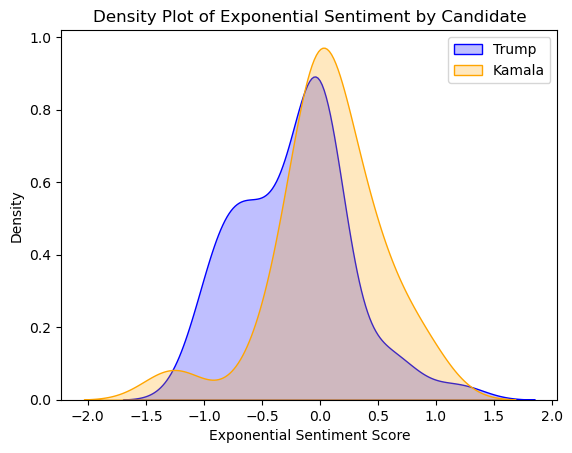

In [17]:
import seaborn as sns

sns.kdeplot(data=df[df["Candidate"] == "Trump"], x="Exponential Sentiment", label="Trump", shade=True, color="blue")
sns.kdeplot(data=df[df["Candidate"] == "Kamala"], x="Exponential Sentiment", label="Kamala", shade=True, color="orange")
plt.title("Density Plot of Exponential Sentiment by Candidate")
plt.xlabel("Exponential Sentiment Score")
plt.legend()
plt.show()
